In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.backends
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
import anndata as an
import scipy



In [8]:
# Enter the name of your input file here
inputFile = "seurat.txt"
# Input parameters
nGene = 50
nCell = 3

try:
    os.stat("ComplexityPlots")
except:
    os.mkdir("ComplexityPlots")
    
# Read in DGE Files    
fileNames = pd.read_csv(inputFile, sep = "\t")
fileNames

,Sample,DGE SilePath,Reads SilePath,Soup
0,AB1,L:/Duncan/Pn3Pilot/ReRunDGEs/AB1_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AB1_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt
1,AB2,L:/Duncan/Pn3Pilot/ReRunDGEs/AB2_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AB2_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt
2,AB3,L:/Duncan/Pn3Pilot/ReRunDGEs/AB3_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AB3_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt
3,AB4,L:/Duncan/Pn3Pilot/ReRunDGEs/AB4_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AB4_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt
4,AC1,L:/Duncan/Pn3Pilot/ReRunDGEs/AC1_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AC1_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt
5,AC2,L:/Duncan/Pn3Pilot/ReRunDGEs/AC2_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AC2_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt
6,AC3,L:/Duncan/Pn3Pilot/ReRunDGEs/AC3_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AC3_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt
7,AC4,L:/Duncan/Pn3Pilot/ReRunDGEs/AC4_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AC4_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt
8,AC5,L:/Duncan/Pn3Pilot/ReRunDGEs/AC5_20230113_DGE....,L:/Duncan/Pn3Pilot/ReRunDGEs/AC5_20230113_read...,L:/Duncan/Pn3Pilot/ReRunDGEs/S1_20230113_soup.txt


In [9]:
tic = time.time()
first = True
for i in range(0,fileNames.shape[0]):
        
    # read and print sample name
    sampName = str(fileNames.Sample.iloc[i])
    print(sampName)
        
    # read in DGE and readCounts files, calculate nUMI
    cells = pd.read_csv(fileNames.values[i,1], index_col = 0, header = 0, delim_whitespace = True)
    nUMIs = cells.sum(axis = 0)
    readCounts = pd.read_csv(fileNames.values[i,2], index_col = 0, header = 0, delim_whitespace = True)
    readCounts = readCounts.reindex(index = list(cells))
    cells.index = cells.index.str.upper()
    cells = cells.loc[~cells.index.duplicated(),:]    
    cells

    # plotting 
    spam = plt.figure()
    plt.rcParams['figure.figsize'] = [7,8]
    plt.plot(readCounts['ExonReads'], nUMIs, 'ko')
    plt.xlabel('Total Reads')
    plt.ylabel('Number of UMIs')
    plt.title(str(sampName) + " Complexity")  
    regr = linear_model.LinearRegression()
    regr.fit(X = nUMIs.values.reshape(-1,1), y = readCounts['ExonReads'].values)
    plt.plot(X = nUMIs.values.reshape(-1,1), Y = regr.predict(nUMIs.values.reshape(-1,1)))
    c = np.array2string(regr.coef_[0])
    plt.annotate("Complexity = " + c, (0,plt.ylim()[1]*.95))
    plt.savefig(fname = "ComplexityPlots/" + str(sampName) + '.png')
    plt.close()
        
    # filter by nGene
    keepcells = (cells.values>0).sum(axis = 0) > nGene
    keepgenes = (cells.values > 0).sum(axis = 1) > nCell
    cells = cells.loc[keepgenes, keepcells]
        
    readCounts = readCounts[:][keepcells]
    n = cells.shape[1]

    # rename columns of data frame to prevent barcode collisions
    identsadd = [sampName]*n
    index = [identsadd[i] + "_" + str(i) for i in range(0, len(identsadd))]
    cells.columns = index
    bcs = readCounts.index.values
    print(len(bcs))
    
    if first:
        cellsAll = cells.copy()
        readCountsAll = readCounts.copy()
        bcsAll= bcs.copy()
        first = False
        idents_all = identsadd

    else:
        cellsAll = pd.DataFrame.join(cellsAll, cells, how = 'outer')
        readCountsAll = readCountsAll.append(readCounts)
        bcsAll = np.append(bcsAll, bcs)
        idents_all = np.append(idents_all, identsadd)
        
toc = time.time()
print(toc - tic)
cellsAll = cellsAll.fillna(0)
cellsAll = cellsAll.reset_index()



AB1
1534
AB2
1632
AB3
3148
AB4
2825
AC1
626
AC2
543
AC3
6768
AC4
2723
AC5
3312
654.7211983203888


In [10]:
import pyarrow.feather
pyarrow.feather.write_feather(cellsAll, 'cellsAll.feather')  
pyarrow.feather.write_feather(readCountsAll, 'readCountsAll.feather')
np.savetxt('bcs.txt', bcsAll, fmt = "%s")

In [11]:
import sys
sys.path.append('../')
from functions import *

# read in and fix data
cells = pd.read_feather('cellsAll.feather')
cells.index = cells.loc[:, 'Gene']
cells = cells.drop('Gene', axis = 1)

filtered out 254 genes that are detected in less than 3 cells
filtered out 72 cells that have less than 50 genes expressed
AnnData object with n_obs × n_vars = 23039 × 12569
    obs: 'orig', 'bc', 'n_genes'
    var: 'n_cells'
normalizing by total count per cell
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    Gene indices [797, 1455, 3538, 6665] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:02)
regressing out n_counts


C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig' as categorical
C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\lib\site-packages\anndata\_core\anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'bc' as categorical


    finished (0:00:54)
linear scaling
computing PCA
    with n_comps=50
    finished (0:00:05)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
    computing neighbors
    using 'X_pca' with n_pcs = 10
    computed neighbors (0:00:55)
    computed connectivities (0:00:08)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:03)
computing UMAP


  0%|          | 0/200 [00:00<?, ?it/s]

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:50)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:42)


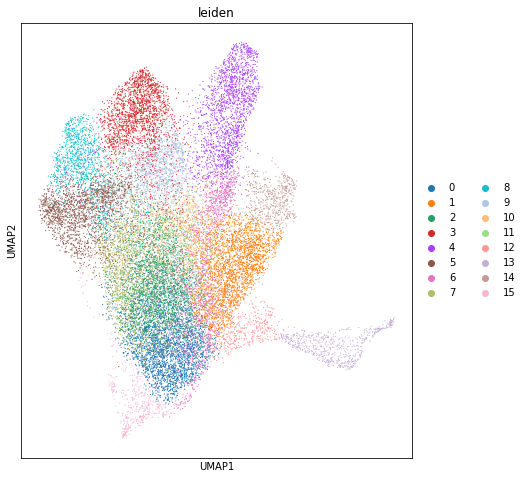

In [12]:
# SCANPY
sc.settings.verbosity = 4
adata = an.AnnData(cells.values.transpose())
adata.var_names = cells.index
adata.obs_names = cells.columns
bcs = np.loadtxt('bcs.txt', dtype = str)
adata.obs['orig'] =[x.split('_')[0] for x in adata.obs_names]
adata.obs['bc']= bcs
adata.obs_names_make_unique()
adata.var_names_make_unique()
adata
sc.pp.filter_genes(adata, min_cells = 3)
sc.pp.filter_cells(adata, min_genes = nGene)
print(adata)

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

adata = process(adata)


In [15]:
umi_fixed = pd.read_csv('umi_corrected.csv', index_col = 0)
umi_fixed['correct'] = [x[2:14] for x in umi_fixed.correct]
umi_fixed['id'] = [umi_fixed['sample'].iloc[x] + umi_fixed.correct.iloc[x] for x in range(0, umi_fixed.shape[0])]
adata.obs['id'] = [adata.obs.orig[x] + adata.obs.bc[x] for x in range(0, adata.shape[0])]
adata.obs.head()
umi_fixed.head()

,Barcode,TotalReads,MappedReads,ExonReads,sample,byte,correct,id
0,CTGTACAACAAG,570426,550101,138134,AB3,b'CTGTACAACAAG',CTGTACAACAAG,AB3CTGTACAACAAG
1,ACTACAGTATTC,488619,464345,115400,AB3,b'ACTACAGTATTC',ACTACAGTATTC,AB3ACTACAGTATTC
2,TCGCAATCACCT,342224,329479,102223,AB3,b'TCGCAATCACCT',TCGCAATCACCT,AB3TCGCAATCACCT
3,TGTTACTAATGA,464673,446651,101983,AB3,b'TGTTACTAATGA',TGTTACTAATGA,AB3TGTTACTAATGA
4,AAAATAAGGTAG,419713,403945,101260,AB3,b'AAAATAAGGTAG',AAAATAAGGTAG,AB3AAAATAAGGTAG


In [17]:
human_meta = pd.read_csv('human/pn3_human_meta.txt')
human_meta.head()

,Unnamed: 0,orig,bc,n_genes,n_counts,leiden,id,quality_BC
0,AB1_0,AB1,AAAAAACCTGTC,1809,4373.0,7,AB1AAAAAACCTGTC,True
1,AB1_1,AB1,AAAAAGAGGCTA,697,1190.0,6,AB1AAAAAGAGGCTA,True
2,AB1_2,AB1,AAAACTCTACGT,73,94.0,3,AB1AAAACTCTACGT,True
3,AB1_3,AB1,AAAAGACCTGTC,73,82.0,1,AB1AAAAGACCTGTC,False
4,AB1_4,AB1,AAAAGGCCGGGG,488,795.0,7,AB1AAAAGGCCGGGG,True


In [25]:
adata.obs[~adata.obs.id.isin(human_meta.id)].sort_values(by = 'n_genes', ascending = False).head(60)

,orig,bc,n_genes,n_counts,leiden,id,quality_BC
AB1_1265,AB1,TCCGCGACTCTC,2482,7278.0,15,AB1TCCGCGACTCTC,True
AB1_1024,AB1,GGTCTCTAGTTA,2343,6214.0,14,AB1GGTCTCTAGTTA,True
AB1_1204,AB1,TAGTTTTACGCT,2316,5964.0,4,AB1TAGTTTTACGCT,True
AB1_693,AB1,CTGGATCATCAA,2107,6370.0,14,AB1CTGGATCATCAA,True
AC2_492,AC2,TCGTGGTAGATA,2080,8273.0,15,AC2TCGTGGTAGATA,True
AB1_1263,AB1,TCCGCAAAGTCC,1941,5166.0,14,AB1TCCGCAAAGTCC,True
AB1_924,AB1,GGAACCCTAAAT,1843,4603.0,14,AB1GGAACCCTAAAT,True
AB1_1451,AB1,TTCCAACCGTAG,1788,4430.0,14,AB1TTCCAACCGTAG,True
AB1_1501,AB1,TTGCGCATCCAT,1780,4608.0,1,AB1TTGCGCATCCAT,True
AB1_1127,AB1,GTTGCCGTTGTA,1761,3998.0,14,AB1GTTGCCGTTGTA,True


In [14]:
adata.obs['id'] = [adata.obs.orig[x] + adata.obs.bc[x] for x in range(0, adata.shape[0])]
keepers = adata.obs_names[adata.obs.id.isin(umi_fixed.id)]
adata.obs['quality_BC'] = [x in keepers for x in adata.obs.index]

adata.obs.head()



,orig,bc,n_genes,n_counts,leiden,id,quality_BC
AB1_0,AB1,AAAAAACCTGTC,1779,4373.0,8,AB1AAAAAACCTGTC,True
AB1_1,AB1,AAAAAGAGGCTA,660,1124.0,4,AB1AAAAAGAGGCTA,True
AB1_2,AB1,AAAACGAGGTGC,55,64.0,1,AB1AAAACGAGGTGC,False
AB1_3,AB1,AAAACTCTACGT,63,100.0,0,AB1AAAACTCTACGT,True
AB1_4,AB1,AAAAGACCTGTC,80,92.0,0,AB1AAAAGACCTGTC,False


In [13]:
import pyarrow.feather
def seuratExport(adata, fname):
    df = pd.DataFrame(adata.raw.X.transpose())
    df.columns = adata.obs_names
    df.index = adata.raw.var_names
    df = df.reset_index()
    pyarrow.feather.write_feather(df, fname + '.feather') 
    adata.obs.to_csv(fname + '_meta.txt')
    
seuratExport(adata, 'rhesus_initial')